In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import numpy as np
import sys
sys.path.insert(0, '../Resources')
import MyFunctionsV4 as mfs

In [2]:
player_perform_link = '../CollectedData/final_player_perform_731471.csv'
match_list_link = '../CollectedData/match_list_92820.csv'
player_perform_df = pd.read_csv(player_perform_link)
matches_df = pd.read_csv(match_list_link)

In [3]:
matches_df['winning_club_id'] = matches_df.apply(mfs.winning_club_id, axis=1)

In [4]:
merged_df = pd.merge(player_perform_df, matches_df[['game_id','winning_club_id']], on='game_id', how='left')

In [5]:
merged_df['result'] = merged_df.apply(mfs.win_loss_draw_club_assign, axis = 1)

In [6]:
merged_df = merged_df[['motm','result', 'position', 'rating',
       'goals', 'shots', 'assist', 'passes_made',
       'pass_attempts', 'pass_percent', 'tackles_made', 'tackle_attempts',
                       'red_card', 'gk_saves']]

merged_df.to_csv(f'../CollectedData/motm_merged{len(merged_df)}.csv', index=False)

In [7]:
merged_df.head(3)

,motm,result,position,rating,goals,shots,assist,passes_made,pass_attempts,pass_percent,tackles_made,tackle_attempts,red_card,gk_saves
0,Yes,win,midfielder,8.2,1,1,0,23,31,0.74,2,3,No,0.0
1,No,win,forward,7.9,1,2,1,12,15,0.80,0,1,No,0.0
2,No,win,midfielder,7.8,0,0,0,20,23,0.87,1,3,No,0.0


In [8]:
one_hot = pd.get_dummies(merged_df[['position', 'result']])
merged_df = pd.concat([merged_df, one_hot], axis=1)
merged_df.drop(['position','result'], axis=1, inplace=True)


In [9]:
merged_df.replace({'Yes': 1, 'No': 0}, inplace=True)

In [10]:
merged_df.head(3)
merged_df.motm.value_counts()

0    638489
1     92982
Name: motm, dtype: int64

In [11]:
print(len(merged_df))
merged_df = merged_df[np.isfinite(merged_df).all(1)]
print(len(merged_df))

731471
731471


In [12]:
X = merged_df.drop("motm", axis=1)
y = merged_df.motm

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [14]:
classifier = RandomForestClassifier(n_estimators=750, criterion ='entropy', random_state = 1)

In [15]:
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=750, random_state=1)

In [16]:
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [17]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[153334   6188]
 [ 11213  12133]]


In [18]:
accuracy_score(y_test, y_pred)

0.9048439311415885

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95    159522
           1       0.66      0.52      0.58     23346

    accuracy                           0.90    182868
   macro avg       0.80      0.74      0.76    182868
weighted avg       0.90      0.90      0.90    182868



In [20]:
classifier.feature_importances_

array([3.13448088e-01, 9.39668177e-02, 8.00951383e-02, 2.79068674e-02,
       8.09722454e-02, 9.09866632e-02, 9.30756350e-02, 3.84280871e-02,
       9.30156085e-02, 1.43248314e-03, 8.13814457e-04, 1.09446907e-02,
       2.17045984e-03, 2.07402338e-02, 3.09180690e-04, 5.87076738e-03,
       6.90573429e-03, 2.40133431e-02, 1.49041424e-02])

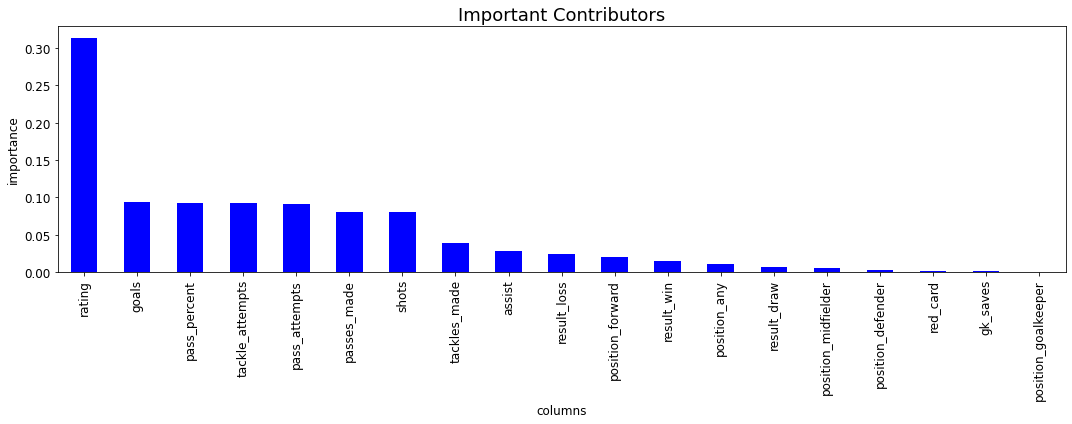

In [21]:
# Generate bar graph of feature importance. 
importance = classifier.feature_importances_
columns = X_train.columns
combined_features = pd.Series(importance, columns)

# sort the combined_features series in descending order
combined_features_sorted = combined_features.sort_values(ascending=False)

# plot the sorted series
pandas_plot = combined_features_sorted.plot.bar(figsize=(15,6), color='b', fontsize = 12)
plt.xlabel("columns", fontsize = 12)
# plt.xticks(rotation = 45)
plt.ylabel("importance", fontsize = 12)
plt.title("Important Contributors for MOTM", fontsize = 18)
plt.tight_layout()
plt.show()

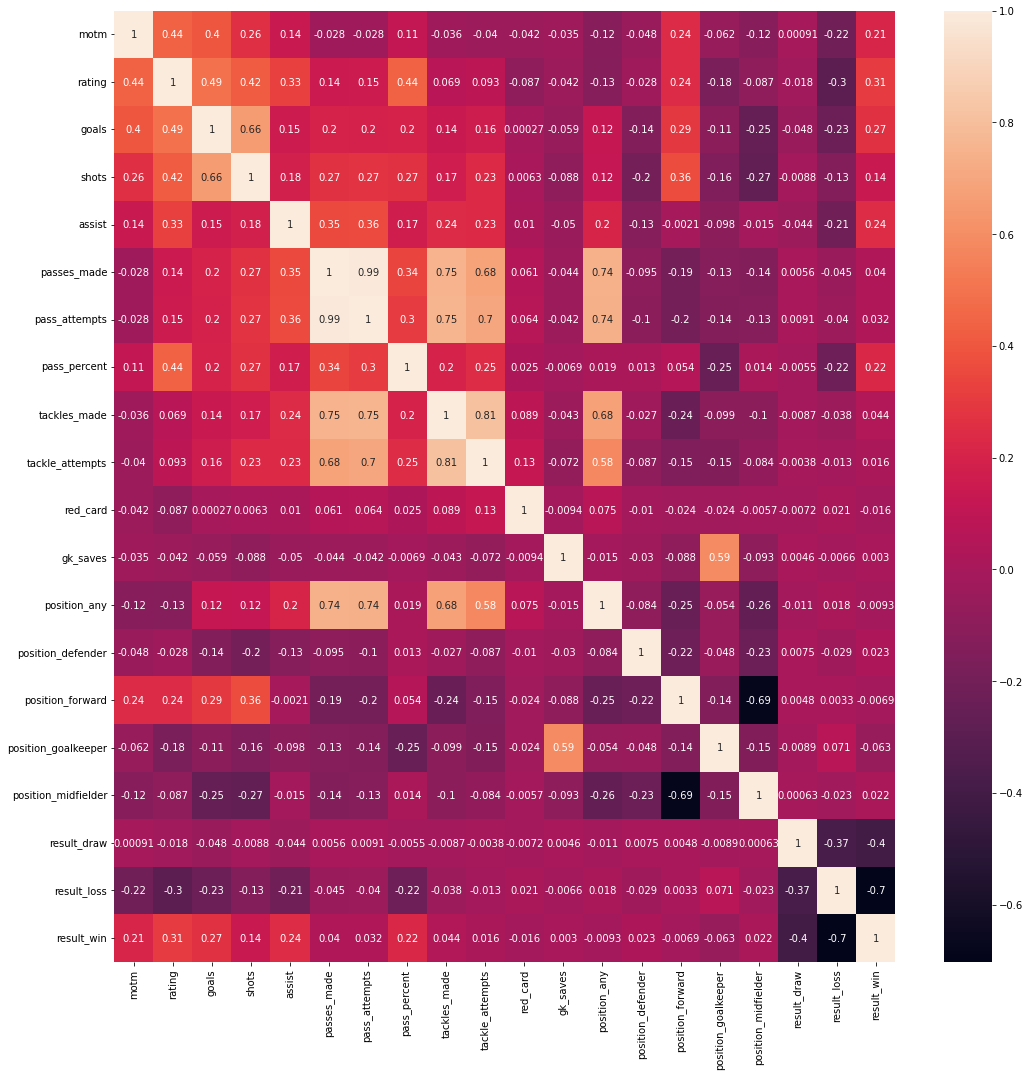

In [22]:
corr_matrix = merged_df.corr()
plt.figure(figsize=(17.5, 17.5)) # Increase the size to 10x10 inches
sn.heatmap(corr_matrix, annot=True)
plt.show()